In [1]:
!pip install --upgrade datasets
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import ast

#Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.4/503.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data_jobs.csv:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/785741 [00:00<?, ? examples/s]

In [2]:
df_US = df[df['job_country'] == 'United States'].copy()
df_skills = df_US.explode('job_skills')

In [3]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()
print(df_skills_count)
type(df_skills_count)

job_skills  job_title_short          
airflow     Business Analyst               38
            Cloud Engineer                 27
            Data Analyst                  387
            Data Engineer                4716
            Data Scientist               1166
                                         ... 
zoom        Machine Learning Engineer       5
            Senior Data Analyst            50
            Senior Data Engineer           30
            Senior Data Scientist          25
            Software Engineer              16
Length: 1870, dtype: int64


pandas.core.series.Series

In [4]:
df_skills_count = df_skills_count.reset_index(name='skill_count')
df_skills_count = df_skills_count.sort_values(by='skill_count', ascending=False)


In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

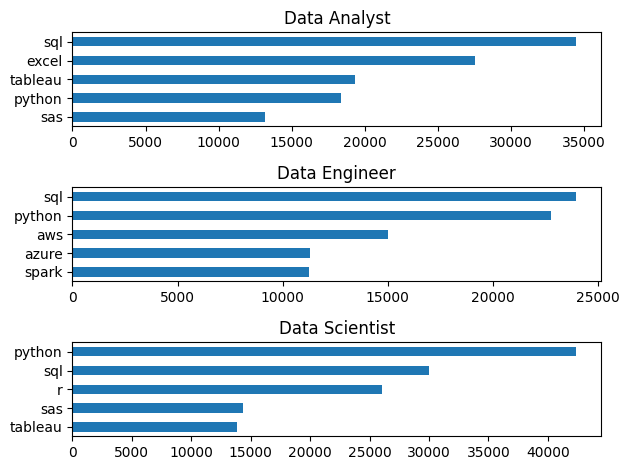

In [6]:
fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
  df_plot = df_skills_count[df_skills_count['job_title_short']==job_title].head(5)
  df_plot.plot(kind='barh', x='job_skills', y='skill_count', ax=ax[i], title=job_title)
  ax[i].invert_yaxis()
  ax[i].set_ylabel('')
  ax[i].legend().remove()

plt.tight_layout()
plt.show()


In [7]:
df_job_title_count =  df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

In [8]:
df_skills_perc = pd.merge(df_skills_count,df_job_title_count, how='left', on='job_title_short')

df_skills_perc['skill_perc'] = 100 * df_skills_perc['skill_count'] / df_skills_perc['jobs_total']

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_perc
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,vue.js,Business Analyst,1,7382,0.013546
1866,arch,Business Analyst,1,7382,0.013546
1867,asana,Machine Learning Engineer,1,921,0.108578
1868,no-sql,Machine Learning Engineer,1,921,0.108578


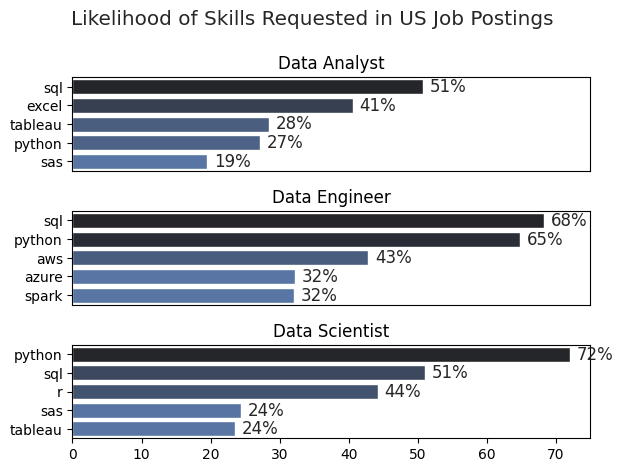

In [9]:
fig, ax = plt.subplots(len(job_titles), 1)
sns.set_theme(style="ticks")

for i, job_title in enumerate(job_titles):
  df_plot = df_skills_perc[df_skills_perc['job_title_short']==job_title].head(5)
  # df_plot.plot(kind='barh', x='job_skills', y='skill_perc', ax=ax[i], title=job_title)

  sns.barplot(x='skill_perc', y='job_skills', data=df_plot, ax=ax[i], orient='h', palette='dark:b_r', hue='skill_count')
  ax[i].set_ylabel('')
  ax[i].set_xlabel('')
  ax[i].legend().remove()
  ax[i].set_title(job_title)
  ax[i].set_xlim(0,75)


  for n, v in enumerate(df_plot['skill_perc']):
    ax[i].text(v+1 ,n, f'{v:.0f}%', va ='center')

  if i != len(job_titles)-1:
    ax[i].set_xticks([])


fig.suptitle('Likelihood of Skills Requested in US Job Postings')
fig.tight_layout()